In [1]:
#Import required packages
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
def format_date(df_date):
    """
    Splits Meeting Times and Dates into datetime objects where applicable using regex.
    """
    df_date['Days'] = df_date['Meeting_Times'].str.extract('([^\s]+)', expand=True)
    df_date['Start_Date'] = df_date['Meeting_Dates'].str.extract('([^\s]+)', expand=True)
    df_date['Year'] = df_date['Term'].astype(str).str.slice(0,4)
    df_date['Quarter'] = df_date['Term'].astype(str).str.slice(4,6)
    df_date['Term_Date'] = pd.to_datetime(df_date['Year'] + df_date['Quarter'], format='%Y%m')
    df_date['Start_Month'] = pd.to_datetime(df_date['Year'] + df_date['Start_Date'], format='%Y%b')
    df_date['End_Date'] = df_date['Meeting_Dates'].str.extract('(?<=-)(.*)(?= )', expand=True)
    #df_date['End_Month'] = pd.to_datetime(df_date['End_Date'], format='%b')
    df_date['Start_Time'] = df_date['Meeting_Times'].str.extract('(?<= )(.*)(?=-)', expand=True)
    df_date['Start_Time'] = pd.to_datetime(df_date['Start_Time'], format='%H%M')
    df_date['End_Time'] = df_date['Meeting_Times'].str.extract('((?<=-).*$)', expand=True)
    df_date['End_Time'] = pd.to_datetime(df_date['End_Time'], format='%H%M')
    df_date['Duration_Hr'] = ((df_date['End_Time'] - df_date['Start_Time']).dt.seconds)/3600
    #df_date = df_date.set_index(pd.DatetimeIndex(df_date['Term_Date']))
    return df_date

def format_xlist(df_xl):
    """
    revises % capacity calculations by using Max Enrollment instead of room capacity.  
    """
    df_xl['Cap_Diff'] = np.where(df_xl['Xlst'] != '', 
                                   df_xl['Max_Enrl'].astype(int) - df_xl['Actual_Enrl'].astype(int), 
                                   df_xl['Room_Capacity'].astype(int) - df_xl['Actual_Enrl'].astype(int)) 
    df_xl = df_xl.loc[df_xl['Room_Capacity'].astype(int) < 999]

    return df_xl


def grouped_plot_graph(df_in):
    fig, ax = plt.subplots()
    grouped = df_in.groupby(['Year', 'Quarter'])
    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='Start_Month', y='Cap_Diff', label=key)
    plt.show()
    
def plot_graph(x_vals, y_vals):
    """
    Plots the dataframe information.
    """
    x = range(len(x_vals))
    plt.figure(figsize=(20,10)) 
    N = 50
    colors = np.random.rand(N)
    sns.stripplot(x_vals, y_vals)
    plt.xticks(rotation=90)
    #plt.scatter(x, y_vals, alpha=0.5, )
    plt.show()

def OLS_operations(y, X):
    #mod = smf.OLS('Cap_Diff ~ C(Dept)', data=df_data)
    mod = sm.OLS(np.asarray(y), X)
    res = mod.fit()
    print(res.summary())
    fig = plt.figure(figsize=(20,10))
    fig = sm.graphics.plot_partregress_grid(mod, fig=fig)
    plt.show()
    
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series.rolling(timeseries, center=False,window=4).mean()
    rolstd = pd.Series.rolling(timeseries, center=False,window=4).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    #plt.figure(figsize=(20,10))
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [7]:
"""
Main program control flow.
"""
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df = pd.read_csv('data/PSU_master_classroom.csv')
df = df.fillna('')

df = format_date(df)
# Avoid classes that only occur on a single day
df = df.loc[df['Start_Date'] != df['End_Date']]
df = df.loc[df['Online Instruct Method'] != 'Fully Online']

# Calculate number of days per week and treat Sunday condition
df['Days_Per_Week'] = df['Days'].str.len()
df['Room_Capacity'] = df['Room_Capacity'].apply(lambda x: x if (x != 'No Data Available') else 0)

df_cl = format_xlist(df)
df_cl = df_cl.groupby('Term_Date').sum()

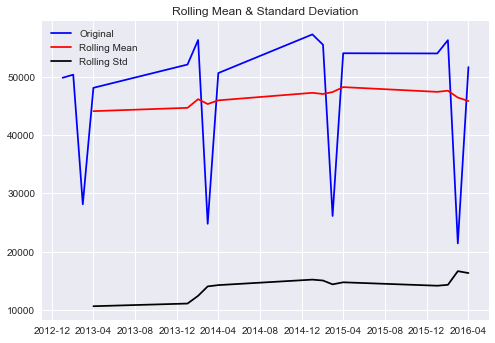

Results of Dickey-Fuller Test:
Test Statistic                -0.814461
p-value                        0.814837
#Lags Used                     6.000000
Number of Observations Used    9.000000
Critical Value (10%)          -2.772382
Critical Value (1%)           -4.473135
Critical Value (5%)           -3.289881
dtype: float64


In [8]:
test_stationarity(df_cl['Cap_Diff'])

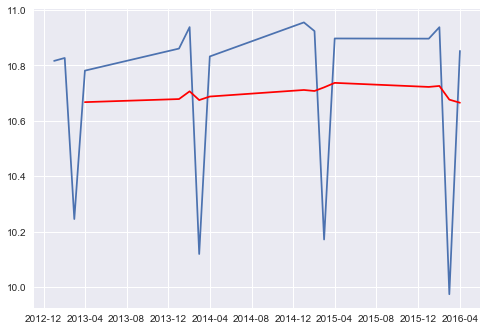

In [13]:
#Estimating and eliminating trend
ts_log = np.log(df_cl['Cap_Diff'])
moving_avg = pd.Series.rolling(ts_log, center=False,window=4).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')
plt.show()


   ===Test stationarity using log moving average===



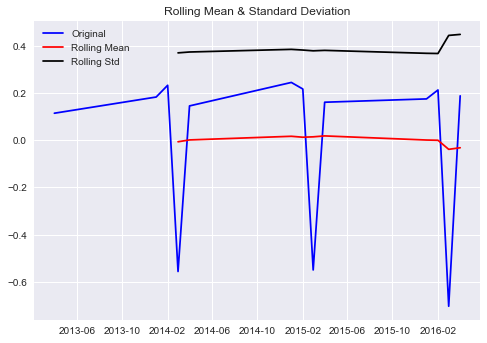

Results of Dickey-Fuller Test:
Test Statistic                 0.000000
p-value                        0.958532
#Lags Used                     6.000000
Number of Observations Used    6.000000
Critical Value (10%)          -2.901198
Critical Value (1%)           -5.354256
Critical Value (5%)           -3.646238
dtype: float64


C:\Users\kms22\AppData\Local\Continuum\Miniconda3\envs\data-science\lib\site-packages\statsmodels\regression\linear_model.py:1148: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


In [14]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(4)
ts_log_moving_avg_diff.dropna(inplace=True)
print("\n   ===Test stationarity using log moving average===\n")
test_stationarity(ts_log_moving_avg_diff)


   ===Use Exponentially Weighted Moving Average===



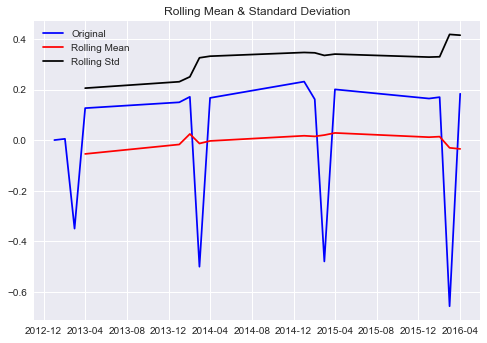

Results of Dickey-Fuller Test:
Test Statistic                -0.649233
p-value                        0.859465
#Lags Used                     6.000000
Number of Observations Used    9.000000
Critical Value (10%)          -2.772382
Critical Value (1%)           -4.473135
Critical Value (5%)           -3.289881
dtype: float64


In [16]:
print("\n   ===Use Exponentially Weighted Moving Average===\n")
expwighted_avg = pd.Series.ewm(ts_log, ignore_na=False,min_periods=0,adjust=True,halflife=4).mean()
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)  


   ===Use Differencing Technique===



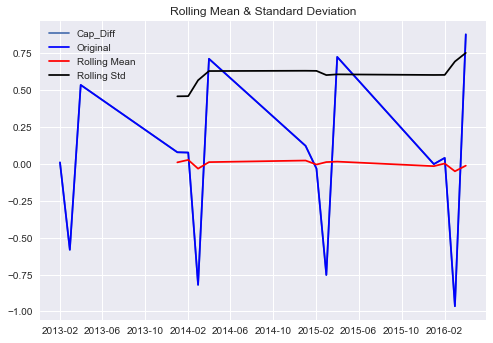

Results of Dickey-Fuller Test:
Test Statistic                -0.000000
p-value                        0.958532
#Lags Used                     6.000000
Number of Observations Used    8.000000
Critical Value (10%)          -2.802961
Critical Value (1%)           -4.665186
Critical Value (5%)           -3.367187
dtype: float64


C:\Users\kms22\AppData\Local\Continuum\Miniconda3\envs\data-science\lib\site-packages\statsmodels\regression\linear_model.py:1148: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


In [17]:
#Differencing
print("\n   ===Use Differencing Technique===\n")
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

C:\Users\kms22\AppData\Local\Continuum\Miniconda3\envs\data-science\lib\site-packages\statsmodels\tsa\filters\filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


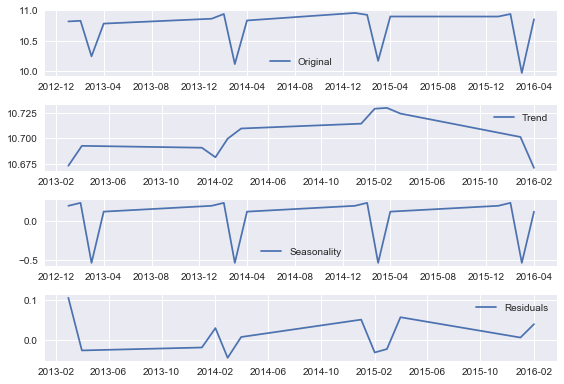

In [18]:
decomposition = seasonal_decompose(ts_log, freq=4)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


   ===Test Stationarity of Residuals===



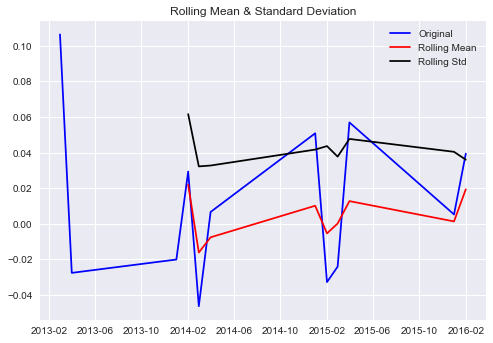

Results of Dickey-Fuller Test:
Test Statistic                -0.534812
p-value                        0.885042
#Lags Used                     3.000000
Number of Observations Used    8.000000
Critical Value (10%)          -2.802961
Critical Value (1%)           -4.665186
Critical Value (5%)           -3.367187
dtype: float64


In [20]:
print("\n   ===Test Stationarity of Residuals===\n")
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

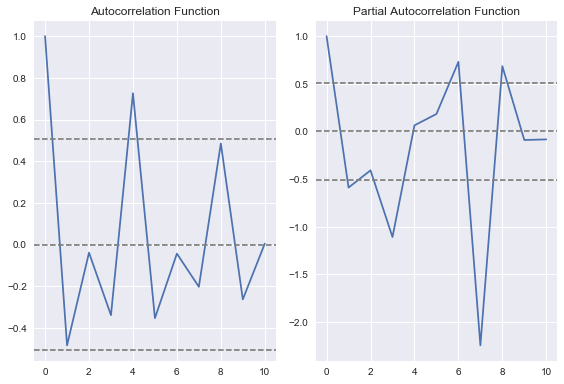

In [32]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf  

lag_acf = acf(ts_log_diff, nlags=10)
lag_pacf = pacf(ts_log_diff, nlags=10, method='ols')

#Plot ACF:    
plt.subplot(121)    
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()

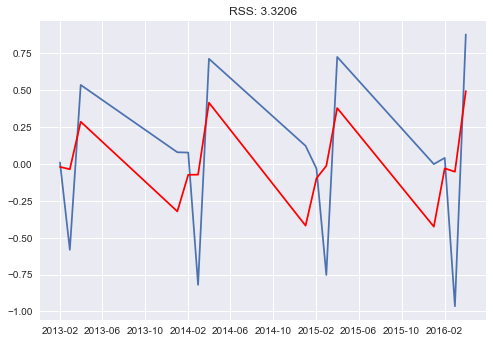

In [46]:
model = ARIMA(ts_log, order=(1, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))
plt.show()

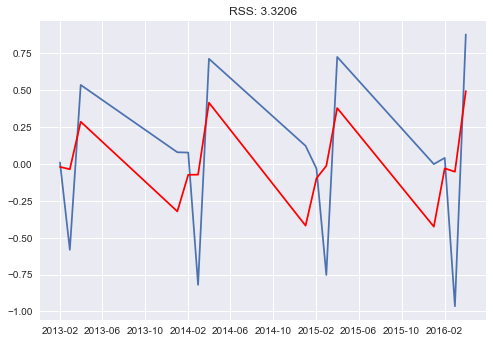

In [54]:
model = ARIMA(ts_log, order=(1, 1, 0))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))
plt.show()